In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth'

In [5]:
simclr_model = torch.load(model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_16488\1145718020.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['sd', 'ex_40']
    #classes = ['cond7_all', 'sd_only']
    #classes = ['cond7_all', 'ex_40']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\train_ex_vs_sd"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1])


# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [11]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:04<00:02,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch features shape: torch.Size([2, 512])
Batch labels shape: torch.Size([2])
Features shape after concatenation: torch.Size([114, 512])
Labels shape after concatenation: torch.Size([114])


 50%|█████     | 1/2 [00:00<00:00,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

Batch features shape: torch.Size([13, 512])
Batch labels shape: torch.Size([13])
Features shape after concatenation: torch.Size([29, 512])
Labels shape after concatenation: torch.Size([29])


In [12]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [13]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [14]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [15]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best by accuracy
    best_test_acc = -1.0
    best_model_state_acc = None

    # Track best by loss (with accuracy as a tiebreaker)
    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Check for best accuracy model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state_acc = model.state_dict()

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Now we have two best states: best_model_state_acc and best_model_state_loss
    # Create two separate model instances for them
    best_acc_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_acc_model.load_state_dict(best_model_state_acc)
    best_acc_model.eval()

    best_loss_model = LogisticRegression(feature_dim, num_classes).to(device)
    best_loss_model.load_state_dict(best_model_state_loss)
    best_loss_model.eval()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return both models and the final results (e.g., last train_acc and test_acc recorded)
    return best_acc_model, best_loss_model, {"train_acc": train_acc, "test_acc": test_acc}


Epoch 1/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.8970, Training accuracy: 0.2895
Test loss: 0.8147, Test accuracy: 0.4483
Epoch 2/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.6917, Training accuracy: 0.5439
Test loss: 0.6248, Test accuracy: 0.6552
Epoch 3/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 284.51it/s]


Training loss: 0.5355, Training accuracy: 0.8333
Test loss: 0.4871, Test accuracy: 0.8276
Epoch 4/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


Training loss: 0.4177, Training accuracy: 0.9386
Test loss: 0.3911, Test accuracy: 0.8966
Epoch 5/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.3329, Training accuracy: 0.9298
Test loss: 0.3237, Test accuracy: 0.8966
Epoch 6/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]


Training loss: 0.2774, Training accuracy: 0.9298
Test loss: 0.2746, Test accuracy: 0.8966
Epoch 7/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.2330, Training accuracy: 0.9298
Test loss: 0.2377, Test accuracy: 0.8966
Epoch 8/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1974, Training accuracy: 0.9474
Test loss: 0.2094, Test accuracy: 0.8966
Epoch 9/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1685, Training accuracy: 0.9474
Test loss: 0.1875, Test accuracy: 0.8966
Epoch 10/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Training loss: 0.1466, Training accuracy: 0.9649
Test loss: 0.1704, Test accuracy: 0.8966
Epoch 11/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1291, Training accuracy: 0.9737
Test loss: 0.1574, Test accuracy: 0.8966
Epoch 12/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1155, Training accuracy: 0.9737
Test loss: 0.1475, Test accuracy: 0.9310
Epoch 13/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.1007, Training accuracy: 0.9912
Test loss: 0.1403, Test accuracy: 0.9310
Epoch 14/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]


Training loss: 0.0911, Training accuracy: 0.9912
Test loss: 0.1350, Test accuracy: 0.9310
Epoch 15/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0835, Training accuracy: 0.9912
Test loss: 0.1312, Test accuracy: 0.9655
Epoch 16/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1412.22it/s]


Training loss: 0.0748, Training accuracy: 1.0000
Test loss: 0.1285, Test accuracy: 0.9655
Epoch 17/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0696, Training accuracy: 1.0000
Test loss: 0.1265, Test accuracy: 0.9655
Epoch 18/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0656, Training accuracy: 1.0000
Test loss: 0.1249, Test accuracy: 0.9655
Epoch 19/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.0600, Training accuracy: 1.0000
Test loss: 0.1238, Test accuracy: 0.9655
Epoch 20/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1222.83it/s]


Training loss: 0.0563, Training accuracy: 1.0000
Test loss: 0.1229, Test accuracy: 0.9655
Epoch 21/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0528, Training accuracy: 1.0000
Test loss: 0.1221, Test accuracy: 0.9655
Epoch 22/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0492, Training accuracy: 1.0000
Test loss: 0.1213, Test accuracy: 0.9655
Epoch 23/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0477, Training accuracy: 1.0000
Test loss: 0.1204, Test accuracy: 0.9655
Epoch 24/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0440, Training accuracy: 1.0000
Test loss: 0.1196, Test accuracy: 0.9655
Epoch 25/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0425, Training accuracy: 1.0000
Test loss: 0.1188, Test accuracy: 0.9655
Epoch 26/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0394, Training accuracy: 1.0000
Test loss: 0.1182, Test accuracy: 0.9655
Epoch 27/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.82it/s]


Training loss: 0.0382, Training accuracy: 1.0000
Test loss: 0.1174, Test accuracy: 0.9655
Epoch 28/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.08it/s]


Training loss: 0.0366, Training accuracy: 1.0000
Test loss: 0.1167, Test accuracy: 0.9655
Epoch 29/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0352, Training accuracy: 1.0000
Test loss: 0.1159, Test accuracy: 0.9655
Epoch 30/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0340, Training accuracy: 1.0000
Test loss: 0.1153, Test accuracy: 0.9655
Epoch 31/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0321, Training accuracy: 1.0000
Test loss: 0.1148, Test accuracy: 0.9655
Epoch 32/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1101.45it/s]


Training loss: 0.0314, Training accuracy: 1.0000
Test loss: 0.1143, Test accuracy: 0.9655
Epoch 33/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0302, Training accuracy: 1.0000
Test loss: 0.1138, Test accuracy: 0.9655
Epoch 34/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.10it/s]


Training loss: 0.0288, Training accuracy: 1.0000
Test loss: 0.1134, Test accuracy: 0.9655
Epoch 35/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0287, Training accuracy: 1.0000
Test loss: 0.1131, Test accuracy: 0.9655
Epoch 36/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.92it/s]


Training loss: 0.0279, Training accuracy: 1.0000
Test loss: 0.1128, Test accuracy: 0.9655
Epoch 37/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 165.90it/s]


Training loss: 0.0267, Training accuracy: 1.0000
Test loss: 0.1126, Test accuracy: 0.9655
Epoch 38/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 889.57it/s]


Training loss: 0.0252, Training accuracy: 1.0000
Test loss: 0.1126, Test accuracy: 0.9655
Epoch 39/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]


Training loss: 0.0254, Training accuracy: 1.0000
Test loss: 0.1126, Test accuracy: 0.9655
Epoch 40/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0249, Training accuracy: 1.0000
Test loss: 0.1125, Test accuracy: 0.9655
Epoch 41/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0231, Training accuracy: 1.0000
Test loss: 0.1127, Test accuracy: 0.9655
Epoch 42/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0230, Training accuracy: 1.0000
Test loss: 0.1128, Test accuracy: 0.9655
Epoch 43/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.32it/s]


Training loss: 0.0220, Training accuracy: 1.0000
Test loss: 0.1130, Test accuracy: 0.9655
Epoch 44/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]


Training loss: 0.0217, Training accuracy: 1.0000
Test loss: 0.1133, Test accuracy: 0.9655
Epoch 45/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.58it/s]


Training loss: 0.0204, Training accuracy: 1.0000
Test loss: 0.1135, Test accuracy: 0.9655
Epoch 46/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0206, Training accuracy: 1.0000
Test loss: 0.1137, Test accuracy: 0.9655
Epoch 47/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0202, Training accuracy: 1.0000
Test loss: 0.1139, Test accuracy: 0.9655
Epoch 48/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0201, Training accuracy: 1.0000
Test loss: 0.1140, Test accuracy: 0.9655
Epoch 49/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0197, Training accuracy: 1.0000
Test loss: 0.1143, Test accuracy: 0.9655
Epoch 50/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.82it/s]


Training loss: 0.0186, Training accuracy: 1.0000
Test loss: 0.1146, Test accuracy: 0.9655
Epoch 51/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0188, Training accuracy: 1.0000
Test loss: 0.1149, Test accuracy: 0.9655
Epoch 52/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 313.57it/s]


Training loss: 0.0183, Training accuracy: 1.0000
Test loss: 0.1152, Test accuracy: 0.9655
Epoch 53/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]


Training loss: 0.0179, Training accuracy: 1.0000
Test loss: 0.1155, Test accuracy: 0.9655
Epoch 54/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 241.34it/s]


Training loss: 0.0172, Training accuracy: 1.0000
Test loss: 0.1159, Test accuracy: 0.9655
Epoch 55/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0168, Training accuracy: 1.0000
Test loss: 0.1162, Test accuracy: 0.9655
Epoch 56/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0164, Training accuracy: 1.0000
Test loss: 0.1165, Test accuracy: 0.9655
Epoch 57/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0161, Training accuracy: 1.0000
Test loss: 0.1169, Test accuracy: 0.9655
Epoch 58/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0163, Training accuracy: 1.0000
Test loss: 0.1172, Test accuracy: 0.9655
Epoch 59/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


Training loss: 0.0157, Training accuracy: 1.0000
Test loss: 0.1175, Test accuracy: 0.9655
Epoch 60/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 289.26it/s]


Training loss: 0.0151, Training accuracy: 1.0000
Test loss: 0.1178, Test accuracy: 0.9655
Epoch 61/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0150, Training accuracy: 1.0000
Test loss: 0.1182, Test accuracy: 0.9655
Epoch 62/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0148, Training accuracy: 1.0000
Test loss: 0.1185, Test accuracy: 0.9655
Epoch 63/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


Training loss: 0.0145, Training accuracy: 1.0000
Test loss: 0.1188, Test accuracy: 0.9655
Epoch 64/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0139, Training accuracy: 1.0000
Test loss: 0.1191, Test accuracy: 0.9655
Epoch 65/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]


Training loss: 0.0139, Training accuracy: 1.0000
Test loss: 0.1193, Test accuracy: 0.9655
Epoch 66/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0134, Training accuracy: 1.0000
Test loss: 0.1196, Test accuracy: 0.9655
Epoch 67/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.53it/s]


Training loss: 0.0133, Training accuracy: 1.0000
Test loss: 0.1198, Test accuracy: 0.9655
Epoch 68/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.58it/s]


Training loss: 0.0129, Training accuracy: 1.0000
Test loss: 0.1200, Test accuracy: 0.9655
Epoch 69/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0128, Training accuracy: 1.0000
Test loss: 0.1202, Test accuracy: 0.9655
Epoch 70/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


Training loss: 0.0126, Training accuracy: 1.0000
Test loss: 0.1204, Test accuracy: 0.9655
Epoch 71/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 67.60it/s]


Training loss: 0.0126, Training accuracy: 1.0000
Test loss: 0.1206, Test accuracy: 0.9655
Epoch 72/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 3964.37it/s]


Training loss: 0.0123, Training accuracy: 1.0000
Test loss: 0.1208, Test accuracy: 0.9655
Epoch 73/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 538.91it/s]


Training loss: 0.0120, Training accuracy: 1.0000
Test loss: 0.1210, Test accuracy: 0.9655
Epoch 74/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 822.25it/s]


Training loss: 0.0118, Training accuracy: 1.0000
Test loss: 0.1212, Test accuracy: 0.9655
Epoch 75/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0114, Training accuracy: 1.0000
Test loss: 0.1215, Test accuracy: 0.9655
Epoch 76/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0114, Training accuracy: 1.0000
Test loss: 0.1215, Test accuracy: 0.9655
Epoch 77/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0117, Training accuracy: 1.0000
Test loss: 0.1215, Test accuracy: 0.9655
Epoch 78/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.44it/s]


Training loss: 0.0115, Training accuracy: 1.0000
Test loss: 0.1216, Test accuracy: 0.9655
Epoch 79/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.20it/s]


Training loss: 0.0115, Training accuracy: 1.0000
Test loss: 0.1216, Test accuracy: 0.9655
Epoch 80/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1216, Test accuracy: 0.9655
Epoch 81/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0118, Training accuracy: 1.0000
Test loss: 0.1216, Test accuracy: 0.9655
Epoch 82/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1217, Test accuracy: 0.9655
Epoch 83/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]


Training loss: 0.0115, Training accuracy: 1.0000
Test loss: 0.1217, Test accuracy: 0.9655
Epoch 84/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0116, Training accuracy: 1.0000
Test loss: 0.1217, Test accuracy: 0.9655
Epoch 85/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1218, Test accuracy: 0.9655
Epoch 86/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1218, Test accuracy: 0.9655
Epoch 87/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 305.55it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1218, Test accuracy: 0.9655
Epoch 88/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.45it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1219, Test accuracy: 0.9655
Epoch 89/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


Training loss: 0.0114, Training accuracy: 1.0000
Test loss: 0.1219, Test accuracy: 0.9655
Epoch 90/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.14it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1219, Test accuracy: 0.9655
Epoch 91/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.76it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1219, Test accuracy: 0.9655
Epoch 92/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1220, Test accuracy: 0.9655
Epoch 93/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1220, Test accuracy: 0.9655
Epoch 94/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1220, Test accuracy: 0.9655
Epoch 95/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Training loss: 0.0115, Training accuracy: 1.0000
Test loss: 0.1220, Test accuracy: 0.9655
Epoch 96/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 878.76it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1221, Test accuracy: 0.9655
Epoch 97/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1221, Test accuracy: 0.9655
Epoch 98/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1221, Test accuracy: 0.9655
Epoch 99/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 100/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 101/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 102/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 103/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 104/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 105/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 106/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 107/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 108/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 109/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.67it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 110/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 111/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 111.87it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 112/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 80.84it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 113/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 114/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 115/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 116/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 189.59it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 117/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 118/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 96.18it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 119/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 122.13it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 120/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 121/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 122/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 123/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 651.49it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1222, Test accuracy: 0.9655
Epoch 124/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 125/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 126/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.90it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 127/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 128/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 288.41it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 129/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 469.06it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 130/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.54it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 131/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 132/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 133/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 134/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1372.93it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 135/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 136/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 137/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 138/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 139/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 181.45it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 140/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 141/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.50it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 142/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.59it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 143/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0114, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 144/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 145/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 468.53it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 146/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 147/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 148/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 149/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.22it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 150/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 151/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1223, Test accuracy: 0.9655
Epoch 152/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 153/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.55it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 154/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1068.61it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 155/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 117.38it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 156/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 157/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 125.00it/s]


Training loss: 0.0113, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 158/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 159/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 160/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 249.87it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 161/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 162/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 163/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 189.61it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 164/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 165/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 250.15it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 166/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 167/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 168/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 91.98it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 169/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 257.38it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 170/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1434.44it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 171/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 172/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 173/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1224, Test accuracy: 0.9655
Epoch 174/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 305.31it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 175/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 176/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 320.20it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 177/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 178/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 90.64it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 179/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 148.27it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 180/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 146.78it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 181/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 361.70it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 182/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 183/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 184/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.91it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 185/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 364.88it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 186/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 187/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 188/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 189/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 244.03it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 190/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 191/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 336.65it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 192/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 193/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.14it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 194/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 195/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 196/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 197/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 198/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 199/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 67.88it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 200/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.15it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1225, Test accuracy: 0.9655
Epoch 201/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 767.20it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 202/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 104.26it/s]


Training loss: 0.0112, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 203/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 204/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 1130.54it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 205/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 206/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 54.27it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 207/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 208/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 201.57it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 209/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 187.10it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 210/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 211/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 212/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 213/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 199.64it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 214/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 73.22it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 215/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 216/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 55.85it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 217/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 111.09it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 218/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 219/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 220/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


Training loss: 0.0111, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 221/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.03it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 222/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 354.52it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 223/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 224/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 307.01it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1226, Test accuracy: 0.9655
Epoch 225/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 226/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0110, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 227/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 302.93it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 228/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 229/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 133.75it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 230/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 231/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.54it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 232/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 306.78it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 233/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 71.31it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 234/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.62it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 235/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 333.46it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 236/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 237/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 333.30it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 238/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]


Training loss: 0.0104, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 239/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 108.25it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 240/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 133.18it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 241/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 242/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 192.47it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 243/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 428.43it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 244/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]


Training loss: 0.0107, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 245/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0106, Training accuracy: 1.0000
Test loss: 0.1227, Test accuracy: 0.9655
Epoch 246/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 60.24it/s]


Training loss: 0.0105, Training accuracy: 1.0000
Test loss: 0.1228, Test accuracy: 0.9655
Epoch 247/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1228, Test accuracy: 0.9655
Epoch 248/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


Training loss: 0.0108, Training accuracy: 1.0000
Test loss: 0.1228, Test accuracy: 0.9655
Epoch 249/250


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 54.98it/s]


Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1228, Test accuracy: 0.9655
Epoch 250/250


Evaluating: 100%|██████████| 1/1 [00:00<?, ?it/s]

Training loss: 0.0109, Training accuracy: 1.0000
Test loss: 0.1228, Test accuracy: 0.9655


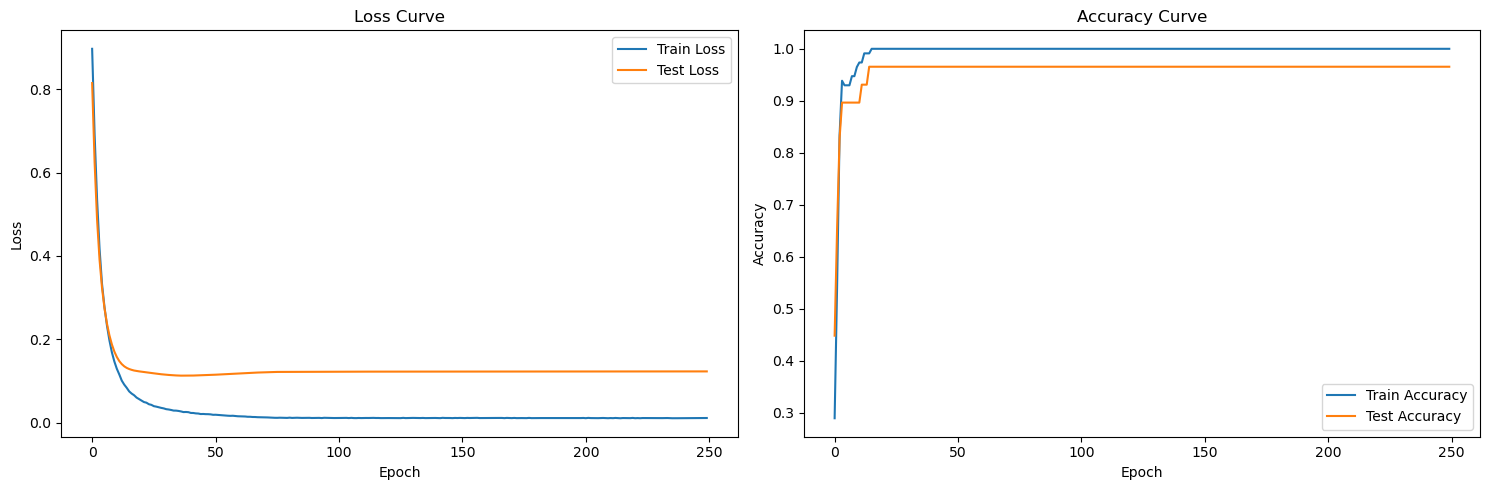

In [16]:
# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=64,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=250
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [17]:
logreg_model= best_loss_model
logreg_model
logreg_model.eval()  # This disables dropout and batchnorm for inference

LogisticRegression(
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

Extracting Features: 100%|██████████| 39/39 [04:28<00:00,  6.87s/it]


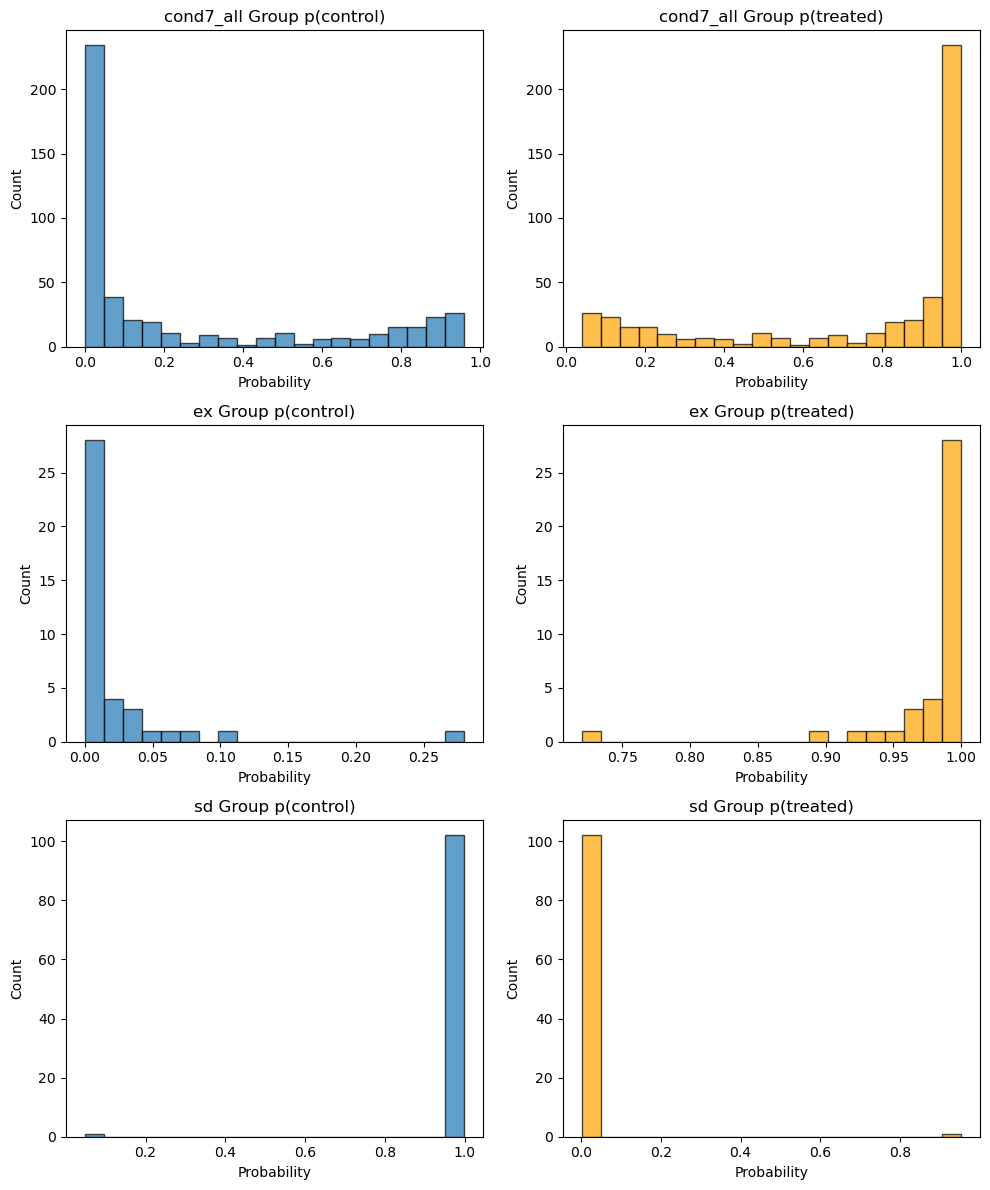

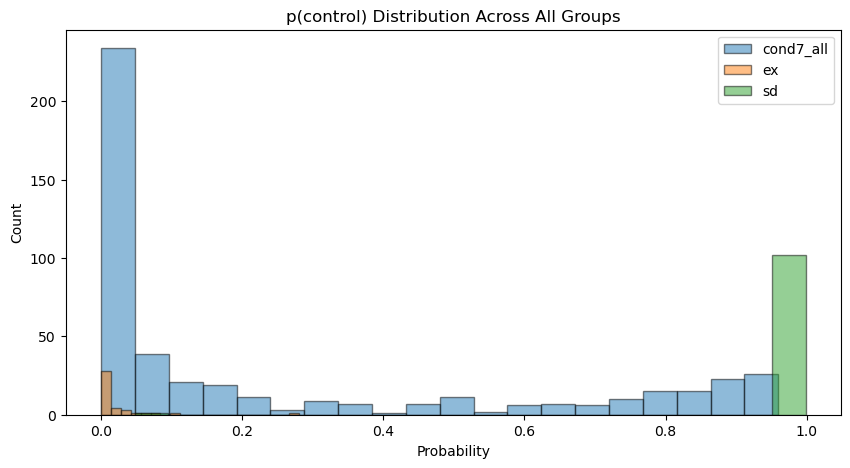

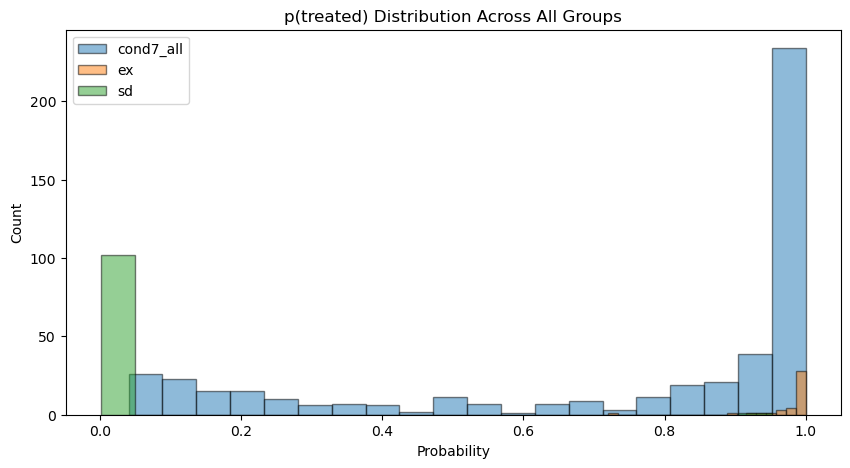

In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"G:\softmax\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [19]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

Images sorted by p(treated) in ascending order:
G:\softmax\inference\sd\RBT10_G07-T01.tiff: 0.0014
G:\softmax\inference\sd\RBT09_G10-T01.tiff: 0.0016
G:\softmax\inference\sd\RBT09_D11-T01.tiff: 0.0022
G:\softmax\inference\sd\RBT10_B09-T01.tiff: 0.0023
G:\softmax\inference\sd\RBT14_B09-T01.tiff: 0.0024
G:\softmax\inference\sd\RBT04_D08-T01.tiff: 0.0024
G:\softmax\inference\sd\RBT14_B10-T01.tiff: 0.0026
G:\softmax\inference\sd\RBT10_C11-T01.tiff: 0.0027
G:\softmax\inference\sd\RBT10_F11-T01.tiff: 0.0027
G:\softmax\inference\sd\RBT10_B10-T01.tiff: 0.0027
G:\softmax\inference\sd\RBT04_D11-T01.tiff: 0.0028
G:\softmax\inference\sd\RBT10_G10-T01.tiff: 0.0028
G:\softmax\inference\sd\RBT09_G08-T01.tiff: 0.0031
G:\softmax\inference\sd\RBT14_B11-T01.tiff: 0.0032
G:\softmax\inference\sd\RBT10_F07-T01.tiff: 0.0032
G:\softmax\inference\sd\RBT09_B10-T01.tiff: 0.0032
G:\softmax\inference\sd\RBT14_B07-T01.tiff: 0.0033
G:\softmax\inference\sd\RBT10_C07-T01.tiff: 0.0034
G:\softmax\inference\sd\RBT14_C08-

# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [20]:
def calculate_custom_accuracy(groups_data):
    """
    Calculate custom accuracy with group name tracking.
    
    Parameters:
    groups_data : dict
        Dictionary with group names as keys and lists of [p_control, p_treated, path] as values
    
    Returns:
    float: Calculated accuracy
    dict: Detailed accuracy metrics
    """
    # Extract probabilities and group names
    group_names = list(groups_data.keys())
    class_probabilities = [
        [item[1] for item in groups_data[group]]  # p_treated probabilities
        for group in group_names
    ]
    
    # Calculate means for each group
    class_means = [np.mean(probs) for probs in class_probabilities]
    
    # Sort means with corresponding group names
    sorted_means = sorted(zip(group_names, class_means), key=lambda x: x[1])
    
    # Identify middle, first, and third classes
    first_class_name = sorted_means[0][0]
    middle_class_name = sorted_means[1][0]
    third_class_name = sorted_means[2][0]
    
    # Rest of the calculation remains the same as previous implementation
    middle_class_index = group_names.index(middle_class_name)
    
    # Find min and max of middle class
    middle_class_probs = class_probabilities[middle_class_index]
    middle_class_min = min(middle_class_probs)
    middle_class_max = max(middle_class_probs)
    
    # Error Calculation
    first_class_index = group_names.index(first_class_name)
    third_class_index = group_names.index(third_class_name)
    
    first_class_errors = sum(1 for prob in class_probabilities[first_class_index] 
                              if prob > middle_class_min)
    
    third_class_errors = sum(1 for prob in class_probabilities[third_class_index] 
                              if prob < middle_class_max)
    
    # Total points and total errors
    total_points = sum(len(probs) for probs in class_probabilities)
    total_errors = first_class_errors + third_class_errors
    
    # Accuracy calculation
    accuracy = (total_points - total_errors) / total_points
    
    # Print class information
    print(f"First class according to mean: {first_class_name}")
    print(f"Middle class according to mean: {middle_class_name}")
    print(f"Third class according to mean: {third_class_name}")
    
    return accuracy, {
        'group_names': group_names,
        'class_means': dict(zip(group_names, class_means)),
        'middle_class_name': middle_class_name,
        'middle_class_min': middle_class_min,
        'middle_class_max': middle_class_max,
        'first_class_errors': first_class_errors,
        'third_class_errors': third_class_errors,
        'total_points': total_points,
        'total_errors': total_errors
    }

# Simplified usage
def apply_accuracy_calculation(groups_data):
    """
    Apply accuracy calculation to the groups data.
    
    Parameters:
    groups_data : dict
        Dictionary with group names as keys and lists of [p_control, p_treated, path] as values
    
    Returns:
    float: Calculated accuracy
    """
    accuracy, metrics = calculate_custom_accuracy(groups_data)
    
    print(f"\nCalculated Accuracy: {accuracy:.4f}")
    print("\nDetailed Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    return accuracy

In [21]:
print(apply_accuracy_calculation(groups_data))

First class according to mean: sd
Middle class according to mean: cond7_all
Third class according to mean: ex

Calculated Accuracy: 0.9350

Detailed Metrics:
group_names: ['cond7_all', 'ex', 'sd']
class_means: {'cond7_all': 0.74915844, 'ex': 0.97972775, 'sd': 0.01753149}
middle_class_name: cond7_all
middle_class_min: 0.04025571793317795
middle_class_max: 0.9999994039535522
first_class_errors: 1
third_class_errors: 39
total_points: 615
total_errors: 40
0.9349593495934959


def calculate_custom_accuracy(class_probabilities):
    """
    Calculate custom accuracy based on the specified method.
    
    Parameters:
    class_probabilities : list of lists
        Each inner list contains probabilities for a class
        [[class1_probs], [class2_probs], [class3_probs]]
    
    Returns:
    float: Calculated accuracy
    dict: Detailed accuracy metrics
    """
    # Task 1: Calculate mean for each class
    class_means = [np.mean(probs) for probs in class_probabilities]
    
    # Task 2: Identify middle class
    sorted_means = sorted(enumerate(class_means), key=lambda x: x[1])
    middle_class_index = sorted_means[1][0]
    
    # Task 3: Find min and max of middle class
    middle_class_probs = class_probabilities[middle_class_index]
    middle_class_min = min(middle_class_probs)
    middle_class_max = max(middle_class_probs)
    
    # Task 4: Error Calculation
    # First class errors: points exceeding middle class min
    first_class_index = sorted_means[0][0]
    third_class_index = sorted_means[2][0]
    
    first_class_errors = sum(1 for prob in class_probabilities[first_class_index] 
                              if prob > middle_class_min)
    
    third_class_errors = sum(1 for prob in class_probabilities[third_class_index] 
                              if prob < middle_class_max)
    
    # Total points and total errors
    total_points = sum(len(probs) for probs in class_probabilities)
    total_errors = first_class_errors + third_class_errors
    
    # Accuracy calculation
    accuracy = (total_points - total_errors) / total_points
    
    return accuracy, {
        'class_means': class_means,
        'middle_class_index': middle_class_index,
        'middle_class_min': middle_class_min,
        'middle_class_max': middle_class_max,
        'first_class_errors': first_class_errors,
        'third_class_errors': third_class_errors,
        'total_points': total_points,
        'total_errors': total_errors
    }

# Example usage
def apply_accuracy_calculation(groups_data):
    """
    Apply accuracy calculation to the groups data from the previous inference script.
    
    Parameters:
    groups_data : dict
        Dictionary with group names as keys and lists of [p_control, p_treated, path] as values
    
    Returns:
    float: Calculated accuracy
    """
    # Separate probabilities by group
    class_probabilities = [
        [item[1] for item in groups_data[group]]  # p_treated probabilities
        for group in groups_data
    ]
    
    accuracy, metrics = calculate_custom_accuracy(class_probabilities)
    
    print(f"Calculated Accuracy: {accuracy:.4f}")
    print("\nDetailed Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    return accuracy

In [22]:
89.992     batch_size=32,

    max_epochs=750

SyntaxError: invalid syntax (4167996181.py, line 1)

In [ ]:
72.68 : # Train the logistic regression model
# Example usage:

    batch_size=16,

    max_epochs=500

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [23]:
85.04 : # Train the logistic regression model
# Example usage:

    batch_size=32,

    max_epochs=500

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


SyntaxError: invalid syntax (2954707542.py, line 1)

In [ ]:
87.80

# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "1000epoch_best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "1000epoch_best_loss_model.pth")


In [24]:
logreg_model = LogisticRegression(512,2)
logreg_model = logreg_model.to(device)

In [ ]:



# Step 2: Load the saved state dict
state_dict = torch.load("1000epoch_best_loss_model.pth")  # Load weights from the file
logreg_model.load_state_dict(state_dict)  # Load state dict into the model

# Step 3: Set the model to evaluation mode (if not training)
logreg_model.eval()  # This disables dropout and batchnorm for inference


# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


In [56]:

# 1000 epochs: no outlier amoung exploded, control7, single dose
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



# Below is inference for ex85.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inf_ex_85"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sort_ex_85"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


# 100 %

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_for_accuracy"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending ordergroups_data[group_name]
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1], entry[0]) for entry in all_images_data]

# Print sorted images
print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr, p_ctrl in sorted_by_treated:
    print(f"{img_path}: p(treated)={p_tr:.4f}, p(control)={p_ctrl:.4f}")

# Initialize group-wise data
grouped_data = {group: [] for group in groups}
for group in groups:
    grouped_data[group].extend(groups_data[group])

# Step 1: Sort distances and keep track of group membership
sorted_distances = []
for group, data in grouped_data.items():
    for _, p_treated, _ in data:
        sorted_distances.append((p_treated, group))

sorted_distances.sort(key=lambda x: x[0])  # Sort by p(treated)

# Step 2: Check for correct transitions between groups
correct_transitions = 0
total_transitions = len(groups) - 1  # Total possible adjacent group transitions

for i in range(total_transitions):
    group_i = groups[i]
    group_j = groups[i + 1]

    # Get all distances for groups i and j
    distances_i = [dist for dist, grp in sorted_distances if grp == group_i]
    distances_j = [dist for dist, grp in sorted_distances if grp == group_j]

    # Check the condition: all d in G_i < all d in G_j
    if all(d_i < d_j for d_i in distances_i for d_j in distances_j):
        correct_transitions += 1

# Step 3: Calculate ranking accuracy
ranking_accuracy = correct_transitions / total_transitions if total_transitions > 0 else 1.0

# Step 4: Print the group-wise ranking accuracy
print("\nGroup-Wise Ranking Accuracy:")
print(f"Correct Transitions: {correct_transitions}")
print(f"Total Possible Transitions: {total_transitions}")
print(f"Ranking Accuracy: {ranking_accuracy:.4f}")


In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_explodall"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import shutil

# Assuming 'sorted_by_treated' is already defined as:
# sorted_by_treated = [(img_path, p_tr), ...] sorted in ascending order by p_tr

new_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sorted_cond10"
os.makedirs(new_dir, exist_ok=True)

for i, (img_path, p_tr) in enumerate(sorted_by_treated, start=1):
    # Extract the parent directory name and the original filename
    parent_dir_name = os.path.basename(os.path.dirname(img_path))  # e.g. "cond7"
    base_filename = os.path.basename(img_path)  # e.g. "ds_41.tif"
    
    # Combine them to get "cond7_ds_41.tif"
    original_filename = f"{parent_dir_name}_{base_filename}"

    # Format the probability score
    formatted_score = f"{p_tr:.4f}"
    
    # Construct the new filename with index and score
    new_filename = f"{i}_{formatted_score}_{original_filename}"
    new_path = os.path.join(new_dir, new_filename)
    
    shutil.copy2(img_path, new_path)

print("Images copied and renamed successfully!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [25]:
#500 epochs, one outlier of exploder in ds closer to sd: which is ds41_g9_C10-T01   inbetween 4 ds closer
# 100 epochs, one outlier of exploder also one outlier from ds_clos_tosd ds41_g5_E04-T01



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

# Inference

In [6]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [7]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
feature_dim = 512 # Set this to the same dimension used during training
num_classes = 2   # Since you trained for 2 classes
logreg_model = LogisticRegression(feature_dim, num_classes).to(device)

# Load the saved weights
logreg_model.load_state_dict(torch.load("best_loss_model.pth", map_location=device))
logreg_model.eval()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for control vs treated classification.

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # We won't use numeric labels for correctness here since our model is only binary.
    # However, we still need a label tensor. We'll just assign a dummy label (e.g. 0) 
    # because we only need to run inference. The label doesn't affect inference.
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

# Dataset that returns image, a dummy label, path, and keeps track of group name externally
class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 2]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 2]
# probs[:, 0] = probability of control
# probs[:, 1] = probability of treated

# Let's store results in a dictionary keyed by group name
# groups_data[group_name] = list of [p_control, p_treated, img_path]
groups_data = {g: [] for g in groups}

# Since group_names aligns with inference_paths and probs, we can pair them up
for p_control, p_treated, grp, path in zip(probs[:,0], probs[:,1], group_names, inference_paths):
    groups_data[grp].append([p_control, p_treated, path])

# Now we have groups_data with each group having a list of probabilities and paths.

# 5. Plot distributions

# Individual distributions per group:
# We'll create subplots dynamically based on how many groups we have.
num_groups = len(groups)
fig, axs = plt.subplots(num_groups, 2, figsize=(10, 4*num_groups))
# axs[i,0] -> p(control) distribution for group i
# axs[i,1] -> p(treated) distribution for group i

if num_groups == 1:
    # If there's only one group, axs is not a 2D array
    axs = np.array([axs])  # make it 2D for consistency

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_treated_list = [item[1] for item in groups_data[grp]]

    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    axs[i, 1].hist(p_treated_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 1].set_title(f"{grp} Group p(treated)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 6. Plot combined distributions
# 6.1: Compare all groups p(control) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# 6.2: Compare all groups p(treated) together
plt.figure(figsize=(10, 5))
for grp in groups:
    p_treated_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_treated_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(treated) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# At this point:
# - We've dynamically handled any number of groups in the directory.
# - We plotted individual probability distributions for each group.
# - We also plotted combined distributions comparing all groups together for both p(control) and p(treated).


# descending order

all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in descending order (highest p(treated) first)
all_images_data.sort(key=lambda x: x[1], reverse=True)

# Now all_images_data is sorted by p(treated)
# Extract (img_path, p_treated)
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

# Print or handle as needed
print("Images sorted by p(treated) in descending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
# ascending order

In [ ]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_treated, img_path]
    all_images_data.extend(groups_data[grp])

# Sort by p(treated) in ascending order
all_images_data.sort(key=lambda x: x[1])  # No reverse=True

# Now all_images_data is sorted by p(treated) in ascending order
sorted_by_treated = [(entry[2], entry[1]) for entry in all_images_data]

print("Images sorted by p(treated) in ascending order:")
for img_path, p_tr in sorted_by_treated:
    print(f"{img_path}: {p_tr:.4f}")

In [15]:
from copy import deepcopy
import torchvision.transforms.functional as TF

In [16]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def Preprocess_Image(image_path):
    # Load the image
    image = tiff.imread(image_path)
    
    # Ensure the image has 3 layers (channels)
    if image.shape[0] != 3:
        raise ValueError(f"Image at {image_path} does not have exactly 3 layers.")
    
    # Normalize the 16-bit image to [0, 1]
    image = image.astype(np.float32) / 65535.0
    
    # Convert to a torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    
    # Resize to (96, 96)
    image = TF.resize(image, (96, 96))
    
    return image


In [18]:
path_of_image = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff'

In [ ]:
first_image = Preprocess_Image(path_of_image)
print(first_image.shape)
prep_first_image = first_image.unsqueeze(0)
print(prep_first_image.shape)

In [ ]:
first_image_np = first_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(first_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('First Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [ ]:
pathimage = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff'
second_image = Preprocess_Image(pathimage)
print(second_image.shape)
prep_second_image = second_image.unsqueeze(0)
print(prep_second_image.shape)


In [ ]:
second_image.shape

In [ ]:
second_image_np = second_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(second_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('second Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [24]:
@torch.no_grad()
def extract_features(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
print(f"simclr_model: {simclr_model}")

In [ ]:
# Extract features for both images
first_image_feats = extract_features(simclr_model, prep_first_image)
second_image_feats = extract_features(simclr_model, prep_second_image)
print(first_image_feats.shape)
print(second_image_feats.shape)

In [ ]:
# COSINE FROM NEWDATA CROP VAL&INFER
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# COSINE old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, second_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
im_path = r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff'
untreated_image = Preprocess_Image(im_path)
print(untreated_image.shape)
prep_untreated_image = untreated_image.unsqueeze(0)
print(prep_untreated_image.shape)

In [ ]:
untreated_image_np = untreated_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(untreated_image_np, cmap='gray')  # Use `cmap='gray'` if it's grayscale
plt.title('untreated Image')
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.show()

In [30]:
untreated_image_feats = extract_features(simclr_model, prep_untreated_image)

In [ ]:
# COSINE NEW DATA CROP
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats, untreated_image_feats, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

Inference after projection head

In [32]:
@torch.no_grad()
def features_after_projection(model, image_tensor):
    # prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Move image tensor to device
    image_tensor = image_tensor.to(device)
    
    # Extract features
    features = network(image_tensor)
    return features

In [ ]:
# Extract features for both images
first_image_feats_after = features_after_projection(simclr_model, prep_first_image)
second_image_feats_after = features_after_projection(simclr_model, prep_second_image)
print(first_image_feats_after.shape)
print(second_image_feats_after.shape)

In [ ]:
# Cosine newdata crop 
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Cosine old data crop
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, second_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

#Cosine similarity between features: 0.8507535457611084


as expected after projection head cosine similarity is higher this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

In [ ]:
untreated_image_feats_after = features_after_projection(simclr_model, prep_untreated_image)
print(untreated_image_feats_after.shape)

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

In [ ]:
# Compute cosine similarity between the feature vectors
cosine_similarity = nn.functional.cosine_similarity(first_image_feats_after, untreated_image_feats_after, dim=1)
print(f"Cosine similarity between features: {cosine_similarity.item()}")

as expected after projection head cosine similarity is lower for different class images this leads to the question that maybe for ranking images with time series, this after projection maybe better option.

Orig images (without simclr)

In [ ]:
print(first_image)
first_image.view(-1).shape


In [ ]:
print(second_image)
second_image.view(-1).shape

In [40]:
first_flat = first_image.view(-1)
second_flat = second_image.view(-1)

In [ ]:
first_flat.unsqueeze(0).shape == untreated_flat.unsqueeze(0)

In [ ]:
import torch.nn.functional as F
similarity = F.cosine_similarity(first_flat.unsqueeze(0), second_flat.unsqueeze(0))
similarity

In [44]:
untreated_flat = untreated_image.view(-1)

In [ ]:
similarity = F.cosine_similarity(first_flat.unsqueeze(0), untreated_flat.unsqueeze(0))
similarity

In [ ]:
first_flat == untreated_flat

orig without resizing

In [ ]:
import numpy as np
import tifffile as tiff
from numpy.linalg import norm

# Load and normalize both images
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")


In [ ]:
im1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
im2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')

# Ensure each image has 3 layers (channels)
if im1.shape[0] != 3 or im2.shape[0] != 3:
    raise ValueError("Each image must have exactly 3 layers.")

# Normalize the 16-bit images to [0, 1]
im1 = im1.astype(np.float32) / 65535.0
im2 = im2.astype(np.float32) / 65535.0
print(im2.shape)

# Flatten the 3D images to 1D vectors
im1_flattened = im1.flatten()
im2_flattened = im2.flatten()
print(im2_flattened.shape)

# Calculate cosine similarity
cosine_similarity = np.dot(im1_flattened, im2_flattened) / (norm(im1_flattened) * norm(im2_flattened))

print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
WAS IST DAS?
Mach kein Sinn!

In [74]:
img1 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B07-T01.tiff')
img2 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose\B08-T01.tiff')
img3 = tiff.imread(r'C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\untreated\D08-T01.tiff')
img1_flattened = img1.flatten()
img2_flattened = img2.flatten()
img3_flattened = img3.flatten()

In [ ]:
cosine_similarity = np.dot(img1_flattened, img2_flattened) / (norm(img1_flattened) * norm(img2_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
cosine_similarity = np.dot(img1_flattened, img3_flattened) / (norm(img1_flattened) * norm(img3_flattened))
print(f"Cosine Similarity between the two images: {cosine_similarity}")

In [ ]:
img1

In [ ]:
img2

In [ ]:
img3

so, if we didn't use simclr and just try to find the cosine similarity between orig images: it doesn't deviate too  much not good.